# Proof of concept

In [1]:
import pickle
import glob
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from scipy.spatial import distance
import uuid
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
from mc_moea import *
pandarallel.initialize(progress_bar=False, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
import gc

In [4]:
def generate_station_manual(x, y, s_info):
    return Station(s_info["types"], x, y, s_info["frequency"], s_info["capacity"], s_info["cost"])

In [5]:
def cartesian_product_transpose(arrays):
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    rows, cols = reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    dtype = np.find_common_type([a.dtype for a in arrays], [])

    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

### Generate small position data

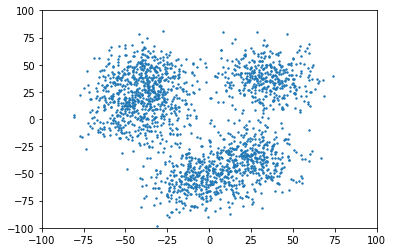

In [21]:
n_clusters = 5
X, y = make_blobs(n_samples=2000, cluster_std=15, centers=n_clusters, n_features=2, center_box=(-60.0, 60.0))
plt.scatter(X[:,0], X[:,1], s=2)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.show()

In [22]:
pickle.dump(X, open("poc_position-small3.pkl", "wb"))

In [6]:
position_df = pickle.load(open("poc_position-small3.pkl", "rb"))

In [7]:
position_df.shape

(2000, 2)

### Stations

In [56]:
station_types = station_types.iloc[-1:]

In [57]:
station_types

,types,frequency,capacity,cost
5,2600 MHz Type II,2600,1300,1350000


In [58]:
s_info = station_types.iloc[-1]

### Simulation parameters

In [59]:
bounding_min = -100
bounding_max = 100

In [60]:
max_station = 5
n_population = 300
crossover_p = 0.3
mutation_p = 0.1
elitism_ratio = 0.5
trim_policy = "best"  # "random" or "best"
num_iters = 400
checkpoint_every = 1

### Initial population

In [66]:
solution_path = "solutions/poc_small/"

In [74]:
# stations_l = [generate_station(n) for n in np.random.randint(1,max_station+1, size=n_population)]
stations_l = []
for s_x in np.random.randint(-100, 100, size=(n_population, 3, 2)):
    station = [generate_station_manual(x[0], x[1], s_info) for x in s_x]
    stations_l.append(station)

solution_pool = [Solution(stations_l[i]) for i in range(n_population)]

solution_df = pd.DataFrame({"solution_id":[x.id for x in solution_pool],
                            "solution_obj": solution_pool,
                            "from_generation":[-1]*n_population,
                            "from_method":["Randomize"]*n_population
                           })
solution_df = compute(solution_df, position_df)
solution_df = solution_df.sort_values(by="fitness_value")
fname = f"{solution_path}/solution-3station-INIT.pkl.bz2"
solution_df.to_pickle(fname, compression="bz2")

In [75]:
solution_df.head()

,solution_id,solution_obj,from_generation,from_method,signal_strength,construction_cost,num_orphans,fitness_value
207,390a445c-4298-413d-a244-bd32dc9ceefc,Solution : 390a445c-4298-413d-a244-bd32dc9ceef...,-1,Randomize,-86.436275,4050000,0,0.887034
276,673d39df-fafc-4f42-bf35-98bf30588460,Solution : 673d39df-fafc-4f42-bf35-98bf3058846...,-1,Randomize,-86.477923,4050000,0,0.887413
48,9721bcf4-586b-4546-98be-ab1a746c5b65,Solution : 9721bcf4-586b-4546-98be-ab1a746c5b6...,-1,Randomize,-86.693868,4050000,0,0.889376
89,4988a818-ed1e-4724-9d77-389f65ca2111,Solution : 4988a818-ed1e-4724-9d77-389f65ca211...,-1,Randomize,-86.703253,4050000,0,0.889461
60,bbb71e08-e9b7-4332-89cc-e2eb78d1cede,Solution : bbb71e08-e9b7-4332-89cc-e2eb78d1ced...,-1,Randomize,-86.782825,4050000,0,0.890185


### Iteration

In [69]:
iteration_best = []
iteration_pattern = []
iteration_df = []

In [72]:
start = 301
num_iters = 601
for i in tqdm(range(start, num_iters)):
    print(f"Iteration {i+1}/{num_iters}")
    
    position = position_df
    
    # print(f"\tFitting with pattern {data_pattern}...")
    print(f"\tComputing fitness value...")
    solution_df = compute(solution_df, position)
    solution_df = solution_df.sort_values(by="fitness_value")
    
    new_solution_df = pd.DataFrame()
    if crossover_p:
        print(f"\tCrossover...")
        crossover_df = crossover(solution_df, crossover_p)
        crossover_df["from_method"] = ["Crossover"]*crossover_df.shape[0]
        new_solution_df = pd.concat([new_solution_df, crossover_df])
    # if mutation_p:
    #     print(f"\tMutation...")
    #     mutation_df = mutation(solution_df, mutation_p)
    #     mutation_df["from_method"] = ["Mutation"]*mutation_df.shape[0]
    #     new_solution_df = pd.concat([new_solution_df, mutation_df])
        
    if new_solution_df.shape[0] != 0:
        print(f"\tComputing fitness value of new solutions...")
        new_solution_df["solution_id"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.id)
        new_solution_df = compute(new_solution_df, position)
        new_solution_df["from_generation"] = [i]*new_solution_df.shape[0]
    
    if elitism_ratio:
        print(f"\tPerforming elite selection and reinitialize...")
        n_elite = int(n_population * elitism_ratio)
        n_reinit = n_population - n_elite
        solution_df = solution_df.sort_values(by="fitness_value").head(n_elite)
        reinit_stations_l = []
        for s_x in np.random.randint(bounding_min, bounding_max, size=(n_reinit, 3, 2)):
            station = [generate_station_manual(x[0], x[1], s_info) for x in s_x]
            reinit_stations_l.append(station)
        # reinit_stations_l = [generate_station(n, lower_bound=-200, upper_bound=200) for n in np.random.randint(1, max_station+1, size=n_reinit)]
        # reinit_stations_l = [generate_station(n) for n in [n_station]*n_reinit]
        reinit_pool = [Solution(s) for s in reinit_stations_l]
        reinit_solution_df = pd.DataFrame({"solution_id":[x.id for x in reinit_pool],
                                          "solution_obj": reinit_pool
                                         })
        reinit_solution_df = compute(reinit_solution_df, position)
        reinit_solution_df["from_generation"] = [i]*reinit_solution_df.shape[0]
        reinit_solution_df["from_method"] = ["Randomize"]*reinit_solution_df.shape[0]
        solution_df = pd.concat([solution_df, reinit_solution_df], ignore_index=True)
    
    print(f"\tTrimming result...")
    if trim_policy=="random":
        print("\t\tRandom trim")
        solution_df = pd.concat([solution_df, new_solution_df], ignore_index=True).sample(n=n_population).reset_index(drop=True)
    else:
        print("\t\tRetain best trim")
        solution_df = pd.concat([solution_df, new_solution_df], ignore_index=True).sort_values(by="fitness_value").head(n_population).reset_index(drop=True)
    
    solution_df = solution_df.sort_values(by="fitness_value")
    best = deepcopy(solution_df[solution_df['fitness_value']==min(solution_df['fitness_value'])])
    iteration_best.append(best)
    # iteration_pattern.append(data_pattern)
    iteration_df.append(deepcopy(solution_df[:10]))
    print(f"\tBest fitness of this iteration: {best['fitness_value'].iloc[0]}")
    if i%checkpoint_every == 0:
        fname = f"solutions/poc/solution-3station-{i:04d}.pkl.bz2"
        print(f"\tSaving checkpint at {fname}")
        solution_df.to_pickle(fname, compression="bz2")
    print(f"\tDone!")

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 302/601
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.8585593709995378
	Saving checkpint at solutions/poc/solution-3station-0301.pkl.bz2
	Done!
Iteration 303/601
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.8585155534871916
	Saving checkpint at solutions/poc/solution-3station-0302.pkl.bz2
	Done!
Iteration 304/601
	Computing fitness value...
	Crossover...
	Computing fitness value of new solutions...
	Performing elite selection and reinitialize...
	Trimming result...
		Retain best trim
	Best fitness of this iteration: 0.8585155534871916
	Saving checkpint at solutions/poc/solution-3station-0303.pkl.bz2
	Done!
Iteration 305/601
	Computing fitness value...
	Cr

KeyboardInterrupt: 

---

## Exhaustive search

In [8]:
from functools import reduce
from itertools import combinations, combinations_with_replacement 

def cartesian_product_transpose(arrays):
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    rows, cols = reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    dtype = np.find_common_type([a.dtype for a in arrays], [])

    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

In [16]:
s_info = station_types.iloc[4]

In [18]:
def generate_station_manual(x, y, s_info):
    return Station(s_info["types"], x, y, s_info["frequency"], s_info["capacity"], s_info["cost"])

In [39]:
point_range = np.arange(-100, 101, 14, dtype=np.int8)

### Case: 3 stations

In [40]:
pos = cartesian_product_transpose([point_range, point_range])
pos.shape

(225, 2)

In [41]:
pos_list = list(combinations(pos, 3))
len(pos_list)

1873200

In [43]:
df = pd.DataFrame(pos_list)
df.columns = ["P1", "P2", "P3"]

In [44]:
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
df["solution_obj"] = df.parallel_apply(lambda x:Solution([
    generate_station_manual(*x["P1"], s_info=s_info),
    generate_station_manual(*x["P2"], s_info=s_info),
    generate_station_manual(*x["P3"], s_info=s_info)
]), axis=1)

In [46]:
df.head()

,P1,P2,P3,solution_obj
0,"[-100, -100]","[-100, -86]","[-100, -72]",Solution : 049d4be7-458f-4ae3-8cc1-7065ff85c5d...
1,"[-100, -100]","[-100, -86]","[-100, -58]",Solution : 35c3d43b-2bd2-4f91-86fb-aab11898503...
2,"[-100, -100]","[-100, -86]","[-100, -44]",Solution : fd8a4726-9e7b-4cf9-8a8c-368de647bcc...
3,"[-100, -100]","[-100, -86]","[-100, -30]",Solution : 7fd1c510-5d1e-4aee-976a-10e4daf78d7...
4,"[-100, -100]","[-100, -86]","[-100, -16]",Solution : 1ede0588-97d0-4e52-8067-caab0b7580e...


In [47]:
pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [48]:
solution_obj_fitted = []
for chunk in tqdm(np.array_split(df["solution_obj"], 500)):
    chunk_result = chunk.parallel_apply(lambda x:x.compute_infos(position_df))
    solution_obj_fitted.append(chunk_result.parallel_apply(lambda x:x.fitness))

  0%|          | 0/500 [00:00<?, ?it/s]

In [49]:
df["fitness"] = pd.concat(solution_obj_fitted)

In [50]:
df.sort_values(by="fitness")

,P1,P2,P3,solution_obj,fitness
1259500,"[-44, 26]","[12, -44]","[40, 40]",Solution : 1d4c396b-2718-4ac0-a7af-d8454af527e...,0.830219
1259485,"[-44, 26]","[12, -44]","[26, 40]",Solution : 16ac8550-09e9-4696-a0f6-77b833a64da...,0.830334
1247565,"[-44, 12]","[12, -44]","[40, 40]",Solution : c2fdc5c9-b6e8-44d2-a7b0-256065bfec1...,0.831283
1247550,"[-44, 12]","[12, -44]","[26, 40]",Solution : dabb9450-d624-42d4-99c1-fcf6d6ba7aa...,0.831329
1420605,"[-30, 26]","[12, -44]","[40, 40]",Solution : d8c33071-6620-457c-a7e7-e41f73851ce...,0.831397
...,...,...,...,...,...
1869034,"[68, 96]","[82, 96]","[96, 96]",Solution : ef9a4f66-527e-4cb0-bcd1-efb964baa6a...,0.977686
1872745,"[96, -100]","[96, -86]","[96, -72]",Solution : 34a2cabf-3e46-498a-89f8-920836e6485...,0.977759
1873199,"[96, 68]","[96, 82]","[96, 96]",Solution : 213ad79b-68fc-4eee-a8be-870520663dc...,0.978249
1869441,"[82, -100]","[96, -100]","[96, -86]",Solution : 49890d39-6bdc-46b3-be15-0edf04a1355...,0.978424


In [17]:
del solution_obj_fitted
solution_obj_fitted = []
gc.collect()

285

In [51]:
df = df.sort_values(by="fitness")

In [52]:
df.head()

,P1,P2,P3,solution_obj,fitness
1259500,"[-44, 26]","[12, -44]","[40, 40]",Solution : 1d4c396b-2718-4ac0-a7af-d8454af527e...,0.830219
1259485,"[-44, 26]","[12, -44]","[26, 40]",Solution : 16ac8550-09e9-4696-a0f6-77b833a64da...,0.830334
1247565,"[-44, 12]","[12, -44]","[40, 40]",Solution : c2fdc5c9-b6e8-44d2-a7b0-256065bfec1...,0.831283
1247550,"[-44, 12]","[12, -44]","[26, 40]",Solution : dabb9450-d624-42d4-99c1-fcf6d6ba7aa...,0.831329
1420605,"[-30, 26]","[12, -44]","[40, 40]",Solution : d8c33071-6620-457c-a7e7-e41f73851ce...,0.831397


In [53]:
df[:1000].to_pickle("exhaustive_search_3station.pkl.bz2", compression="bz2")

In [14]:
df = pd.read_pickle("solutions/poc/solution-0300.pkl.bz2")

In [15]:
df.head()

,solution_id,solution_obj,from_generation,from_method,signal_strength,construction_cost,num_orphans,fitness_value
0,a9e7cb3c-1fe4-46af-8bf6-a5d7ad3d3d28,Solution : a9e7cb3c-1fe4-46af-8bf6-a5d7ad3d3d2...,297,Crossover,-84.210102,2700000,0,0.833046
109,5a00e65d-1228-4946-89dc-d4544b07556d,Solution : 5a00e65d-1228-4946-89dc-d4544b07556...,149,Crossover,-84.232891,2700000,0,0.833254
110,45c9d155-02cc-424d-9b32-5fd0e8077d3b,Solution : 45c9d155-02cc-424d-9b32-5fd0e8077d3...,162,Crossover,-84.232891,2700000,0,0.833254
111,d1323aa4-50e5-495e-a9b6-f72aa3e2a299,Solution : d1323aa4-50e5-495e-a9b6-f72aa3e2a29...,267,Crossover,-84.232891,2700000,0,0.833254
112,5f51810b-3db8-44dc-b896-c1860228aa2b,Solution : 5f51810b-3db8-44dc-b896-c1860228aa2...,214,Crossover,-84.232891,2700000,0,0.833254


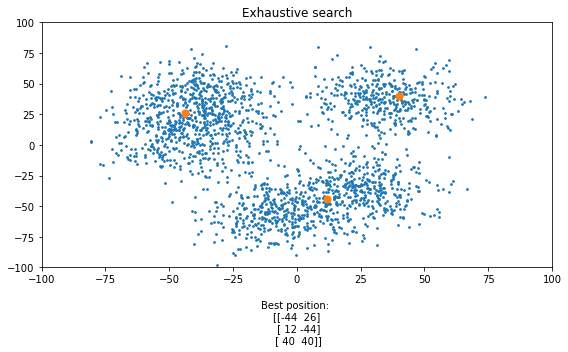

In [54]:
station_pos = np.array([[s.x, s.y] for s in df["solution_obj"].iloc[0].stations])

plt.figure(figsize=(8,5))
plt.scatter(position_df[:,0], position_df[:,1], s=3)
plt.scatter(station_pos[:,0], station_pos[:,1], s=50)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.title("Exhaustive search")
plt.xlabel(f"""
Best position: 
{station_pos}""")
plt.tight_layout()
plt.savefig(f"figure/poc_small/3station_exhaustive.png", bbox_inches = "tight")
plt.show()

In [55]:
station_pos

array([[-44,  26],
       [ 12, -44],
       [ 40,  40]], dtype=int8)

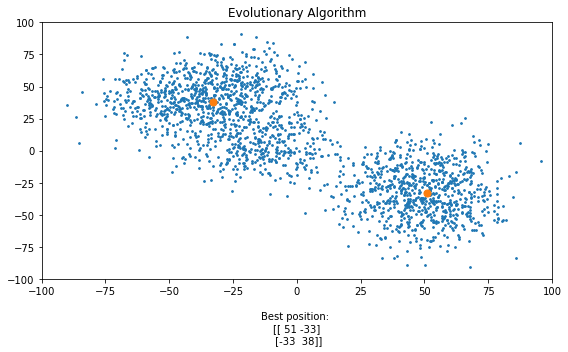

In [79]:
station_pos = np.array([[s.x, s.y] for s in solution_df["solution_obj"].iloc[0].stations])

plt.figure(figsize=(8,5))
plt.scatter(position_df[:,0], position_df[:,1], s=3)
plt.scatter(station_pos[:,0], station_pos[:,1], s=50)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.title("Evolutionary Algorithm")
plt.xlabel(f"""
Best position: 
{station_pos}""")
plt.tight_layout()
plt.savefig(f"figure/poc_small/2station_mc-moea.png", bbox_inches = "tight")
plt.show()